<h1 style="font-weight: big">Movie Industry Margin Analysis by Budget Class</h1>

<figure>
    <img src="Illustrations/Movie Financing.png"
         alt="Movie Financing"
         width="400"
         height="200">
</figure>

<h1 style="font-weight: normal">Overview</h1>

For Microsoft's new movie studio, this project analyzes the trends, tendencies, and genre representation of the most profitable, established, and active studios currently in the industry.

Microsoft can use this information to inform its decision on what movie to produce, what characteristics it should have, and some genres to pursue.

<h1 style="font-weight: normal">Business Problem</h1>

<figure>
    <img src="Illustrations/Movie Set.jpg"
         alt="Movie Set"
         width="400"
         height="200">
</figure>

Microsoft is looking to make a move into the original video content space and is establishing a new studio. Being new to the movie space, Microsoft is looking to understand characteristics and behaviors of profitable films and studios.

Analysis of historical financial trends at the box office will allow Microsoft to gain insight as to how to produce their first movie.

<h1 style="font-weight: normal">Data Understanding</h1>

<figure>
    <img src="Illustrations/Tickets.png"
         alt="Ticket"
         width="300"
         height="150">
</figure>

The project team has gathered historical box office information from Box Office Mojo as well as movie genre and run time from the online IMDB database.

Our primary focus will be on identifying the most profitable studios currently active in the market, and then analyze their recent film outputs for trend and characteristic identification.

In [1]:
import pandas as pd
df_budgets = pd.read_csv("Raw Data/tn.movie_budgets.csv.gz")

<h2 style="font-weight: 100">Box Office Data</h2>

The box office data from Box Office Mojo includes dates as far back as 1915 and as recent as Dec 2020. All numbers reported are in USD and 'worldwide_gross' and is inclusive of 'domestic_gross'

In [2]:
df_budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


<h2 style="font-weight: 100">IMBD Movie information</h2>

The IMBD data we will be pulling will be from the movie_basics table, a table with thousands of records that have information such as runtime, genre, and IMDB movie ID:

In [3]:
### Importing relevant packages for SQL Databse Extraction
import sqlite3
conn = sqlite3.connect("Raw Data/Unzip/im.db")
cur = conn.cursor()

### Extracting Movie Information as a dataframe
df_movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics
""", conn)

<h1 style="font-weight: normal">Data Preparation</h1>

In [4]:
import datetime
import string
punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'

<h2 style="font-weight: 100">Data Cleaning</h2>

In order to make the box office data both easier to work with and easier to merge with other data sets, we will perform the following data cleaning exercises:

- Budget and box office data will have the dollar signs and commas removed 
- Budget and box office data will be formatted as a number
- Release date will be formatted as a date time object
- Movie titles will be stripped of punctuation to make for a friendlier merges later

In [5]:
### Removing dollar signs and commas, and reformatting as a number
df_budgets['worldwide_gross'] = df_budgets['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(float)
df_budgets['domestic_gross'] = df_budgets['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(float)
df_budgets['production_budget'] = df_budgets['production_budget'].str.replace('$', '').str.replace(',', '').astype(float)

### Reformatting release_date as a datetime object
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'])

### Removing punctuation from movie titles
transtab = str.maketrans(dict.fromkeys(punct, ''))
df_budgets['movie'] = '|'.join(df_budgets['movie'].tolist()).translate(transtab).split('|')

<h2 style="font-weight: 100">Feature Engineering</h2>

We added certain columns to create fields that can be merged on later, as well as financial metric columns for further analysis. In short:

- We created a 'year' column from the 'release_date' datetime object
- We created a 'movie_and_year' column, which combines 'movie' and 'year'
- We created a 'international_gross' column, which subtracts 'domestic_gross' from 'worldwide_gross'
- We created a 'profit' column, which is calculated as 'worldwide_gross' - 'production budget'
- We created a 'profit_margin' column, which is calculated as ('profit' / 'worldwide_gross')

We also added a new column, budget_tier, which assigns categories to each of the production budgets based on their value:

- 10m and below: very-low budget
- Between 10m and 30m: low budget
- Between 30m and 50m: middle budget
- Between 50m and 70m: high budget
- Between 70m and up: very-high budget

In [6]:
### Creation of 'year', 'month' and 'movie_and_year' columns
df_budgets['year'] = df_budgets['release_date'].dt.strftime('%Y')
df_budgets['month'] = df_budgets['release_date'].dt.strftime('%b')
df_budgets['movie_and_year'] = df_budgets['movie'] + " - " + df_budgets['year']

### Creation of 'profit' and 'profit_margin' columns
df_budgets['profit'] = df_budgets['worldwide_gross'] - df_budgets['production_budget']
df_budgets['profit_margin'] = (df_budgets['profit'] / df_budgets['worldwide_gross']) * 100

### Converting 'year' back into a numeric value
df_budgets['year'] = df_budgets['year'].map(int)

### Creation of 'international gross' column
df_budgets['international_gross'] = df_budgets['worldwide_gross'] - df_budgets['domestic_gross']

### Adding in a 'budget_tier' column to classify each production budget value
budget_tier = []
for row in df_budgets['production_budget']:
    if row < 10000000 :    budget_tier.append('Very-Low Budget')
    elif row < 30000000:   budget_tier.append('Low Budget')
    elif row < 50000000:  budget_tier.append('Middle Budget')
    elif row < 70000000:  budget_tier.append('High Budget')
    else: budget_tier.append('Super-High Budget')

df_budgets['budget_tier'] = budget_tier

<h2 style="font-weight: 100">Data Filtering</h2>

While considering the business needs of Microsoft, the project team analyzed the data set and found certain subsections of data which would not be relevant for purposes of margin analysis. These subsets of data include:

- Filter 1: Movies that had a very small or non-existant box office release *(less than 50k worldwide_gross)*
- Filter 2: Movies that were release recently *(released after year 2013)*
- Filter 3: Movies with budgets that would likely not be considered business-practical in scope by Microsoft *(budget of less than 500k)*
- Filter 4: Movies that made money (profit margin above 0%)*

In [7]:
### Filter 1
df_budgets = df_budgets[(df_budgets['worldwide_gross'] > 50000)]

### Filter 2
df_budgets = df_budgets[df_budgets['year'] > 2013]

### Filter 3
df_budgets = df_budgets[(df_budgets['production_budget'] > 500000)]

### Filter 4
df_budgets = df_budgets[(df_budgets['profit_margin'] > 0)]

<h2 style="font-weight: 100">Data Merging (to add studio name from additional csv)</h2>

This data will be left merged with "bom.movie_gross.csv.gz" in order to append studio to the movie title

In [8]:
### Importing the CSV
df_studio = pd.read_csv("Raw Data/bom.movie_gross.csv.gz")

### Cleaning punctionation in title and making a movie_and_year column, similar to the budgets file
df_studio['year'] = df_studio['year'].map(str)
df_studio['movie_and_year'] = df_studio['title'] + " - " + df_studio['year']

### Merging the files
df_merged = df_budgets.merge(df_studio, how="left", on="movie_and_year")

Analysis of lost data:

In [9]:
df_merged['title'].isna().sum()

292

292 records were unable to be merged with their affiliated studio, leaving an analysis of 391 profitable movies

In [10]:
df_films_studio_profitable = df_merged[pd.notnull(df_merged['title'])]

<h2 style="font-weight: 100">Data Merging (to add IMBD information)</h2>

For our analysis over the profitable movies produced by the top ten studios, we will merge information found in the movie_basics table of the IMDB database for further analysis of runtime and genres.

In [11]:
### Cleaning the primary title of punctuation
transtab = str.maketrans(dict.fromkeys(punct, ''))
df_movie_basics['primary_title'] = '|'.join(df_movie_basics['primary_title'].tolist()).translate(transtab).split('|')

### Making a 'movie_and_year' column to merge on
df_movie_basics['start_year'] = df_movie_basics['start_year'].map(str)
df_movie_basics['movie_and_year'] = df_movie_basics['primary_title'] + " - " + df_movie_basics['start_year']
df_movie_basics['start_year'] = df_movie_basics['start_year'].map(int)

### Merging movie id
df_half_merge = df_films_studio_profitable.merge(df_movie_basics, how="left", on="movie_and_year")

<h2 style="font-weight: 100">Removing Duplicates from Merge</h2>

Because we did a left merge, we will revmoe for duplicates in the movie_and_year column to ensure values are not over inflated for certain studios or films:

In [12]:
### To check for indexes of duplicate values
index_to_delete = df_half_merge[df_half_merge.duplicated(['movie_and_year'], keep=False)].index
print(f"There are {len(index_to_delete)} duplicate entries on movie_and_year to delete")
print(f"Currently there are {len(df_half_merge.index)} records in the dataframe")

There are 25 duplicate entries on movie_and_year to delete
Currently there are 404 records in the dataframe


In [13]:
len(df_half_merge.index)

404

In [14]:
df_full_merge = df_half_merge.drop(index_to_delete)
print(f"Records after deletion of duplicates: {len(df_full_merge.index)}")

Records after deletion of duplicates: 379


The drop duplicates is complete

<h2 style="font-weight: 100">Determining studios with the highest profit</h2>

In [15]:
import numpy as np

For our analysis, it is important that Microsoft partners with a studio that has a proven track record of profitable movies. As such, we will look for studios with the highest median profit margin that also have put out at least five profitable movies since 2013

In [16]:
### Removes studios with less than five movies:
df_established = df_full_merge.groupby("studio").filter(lambda x: len(x) > 5)

### Creates a pivot table by studio and calculates median profit margin for their profitable films
pivot = pd.pivot_table(df_established, values='profit_margin', index='studio', aggfunc=np.median)

### Sorts by top median profit margin and returns the top ten
pivot.sort_values(by='profit_margin', ascending=False).head(10)

### Creates a list of the top 10 studios
top_10_studios = list(pivot.sort_values(by='profit_margin', ascending=False).head(10).index)

### Filtering the dataframe for only studios in our top 10 list
df = df_established[df_established['studio'].isin(top_10_studios)]

### Printing a pivot of the top ten studios
pivot.sort_values(by='profit_margin', ascending=False).head(10)

,profit_margin
studio,
FoxS,81.079196
Uni.,79.940195
TriS,76.748521
ORF,74.562478
WB (NL),72.794879
Fox,72.053318
SGem,70.724988
Wein.,70.298025
BV,69.819268


<h1 style="font-weight: normal">Data Analysis and Recommendations</h1>

<figure>
    <img src="Illustrations/Movie Set Two.jpg"
         alt="Studio"
         width="300"
         height="150">
</figure>

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

As Microsoft begins to design the first movie it will make as a new studio, the project team recommends the following based off of trends from studios that are currently the most profitable in the business:

- Keep your movie length relatively short, ideally no longer than 104 minutes
- Consider a movie in the Horror, Mystery, and Thriller space, as it both has shown to have the highest return on investment and is under represented in overall genre distribution
- When possible, do a worldwide release as worldwide releases provide higher returns on investment
- Consider partnering with studios with the genre expertise and profitability track record

<h2 style="font-weight: 100">Average length of profitable movies from each studio</h2>

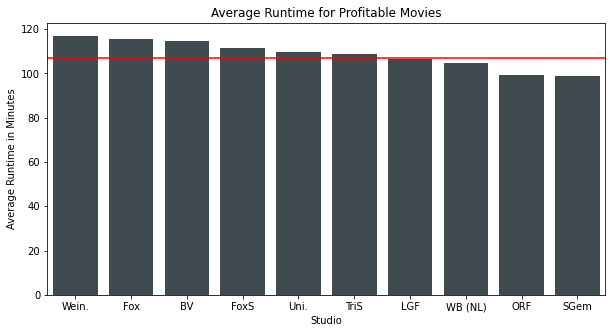

The average movie length at the most profitable, established movie studios is 110 minutes 
The median movie length at the most profitable, established movie studios is 107 minutes 


In [18]:
### Using Seaborn to visualize average runtime per studio, and charting the mean
plt.figure(figsize=(10, 5))
plot_order = df.groupby('studio')['runtime_minutes'].mean().sort_values(ascending=False).index.values
ax = sns.barplot(x='studio', y='runtime_minutes', data=df, color='#3c4c51', ci=None, order=plot_order)
ax.set(xlabel = "Studio", ylabel = "Average Runtime in Minutes", title = "Average Runtime for Profitable Movies")
plt.axhline(df['runtime_minutes'].median(), label ='Mean Runtime', color ='red')

### Displaying figure
plt.show()


### Printing som high level statistical data
print(f"The average movie length at the most profitable, established movie studios is {int(df['runtime_minutes'].mean())} minutes ")
print(f"The median movie length at the most profitable, established movie studios is {int(df['runtime_minutes'].median())} minutes ")

Recommendation: As seen above, the most profitable studios have had their most profitable movies relatively brief, which follows as typical consumption of media is trending towards more bite size entertainment. On their initial outing, Microsoft should consider keeping their movie around this length to maximize appeal and profitability. 

<h2 style="font-weight: 100">International vs. Domestic Release Trends</h2>

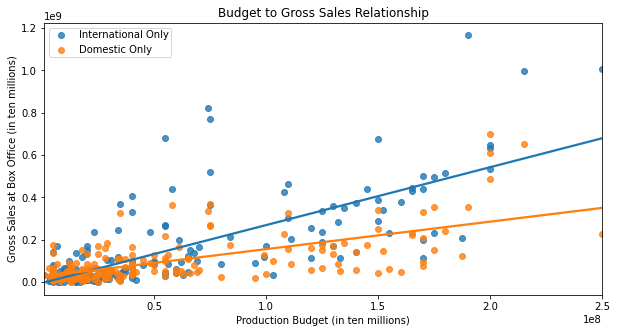

The correlation between production budget and international sales is 0.7505051385563298
The correlation between production budget and domestic only sales is 0.6521353924208009


In [19]:
plt.figure(figsize=(10, 5))
ax = sns.regplot(data=df, x='production_budget', y='international_gross', ci=0, label = 'International Only')
ax = sns.regplot(data=df, x='production_budget', y='domestic_gross_x', ci=0, label = 'Domestic Only')
ax.set(xlabel = "Production Budget (in ten millions)", ylabel = "Gross Sales at Box Office (in ten millions)", title = "Budget to Gross Sales Relationship")
ax.legend(loc='upper left', borderpad=.2)
plt.show()

ww_cor = df['production_budget'].corr(df["international_gross"])
dom_cor = df['production_budget'].corr(df["domestic_gross_x"])


print(f"The correlation between production budget and international sales is {ww_cor}")
print(f"The correlation between production budget and domestic only sales is {dom_cor}")

It is clear from the above analysis that there is a stronger positive correlation between production budget and international box office vs. production budget and domestic budget. Further investigation by budget class:

In [20]:
df_bt = df.groupby("budget_tier").mean()
df_bt_small = df_bt[["international_gross", "domestic_gross_x", "production_budget"]]

df_bt_small.reset_index(inplace=True)
df_bt_small.head()

,budget_tier,international_gross,domestic_gross_x,production_budget
0,High Budget,1.535060e+08,1.011539e+08,5.891000e+07
1,Low Budget,3.881454e+07,5.063792e+07,1.844375e+07
2,Middle Budget,9.021468e+07,7.344584e+07,3.612500e+07
3,Super-High Budget,3.798055e+08,2.029276e+08,1.393680e+08
4,Very-Low Budget,3.206038e+07,3.952003e+07,5.557692e+06


The above data was plotted in excel as after hours of troubleshooting, no side-by-side bar chart was able to be produced in Seaborn. See below for results:

<figure>
    <img src="Illustrations/Average Box Office vs Budget.png"
         alt="Movie Set"
         width="800"
         height="400">
</figure>

Recommendation: As seen above, the a worldwide release is more positively correlated with a worldwide release than a domestic only release. When practical, opt for a worldwide release as it will increase your returns

<h2 style="font-weight: 100">Popular Genre Combinations by Profitability</h2>

In [21]:
### Preparing the dataframe to exclude NaN values when evaluating genres
df_genres = df[df['genres'].notnull()]

### Writing the genres to a list
genre_list = list(df_genres['genres'])

### Looping to create a unique value count of genres and sorting the results
list_of_genres = []

for genre in genre_list:
    add = genre.split(',')
    list_of_genres.append(add)

unique_genres = {}

for genre_list in list_of_genres:
    for genre in genre_list:
        if genre not in unique_genres:
            unique_genres[genre] = 1
        else:
            unique_genres[genre] += 1

unique_genres_sorted = dict(sorted(unique_genres.items(), key=lambda x:x[1], reverse=True))

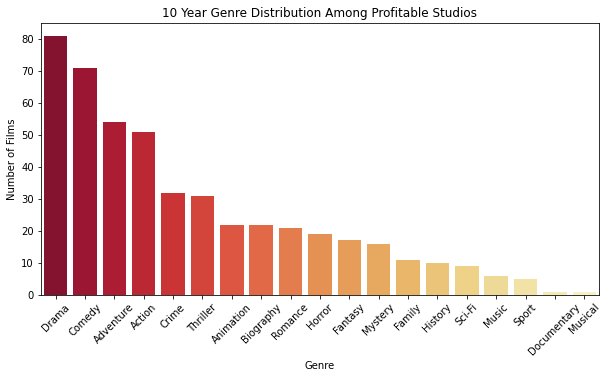

In [22]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=list(unique_genres_sorted.keys()), y=list(unique_genres_sorted.values()), data=df, palette="YlOrRd_r")
ax.set(xlabel = "Genre", ylabel = "Number of Films", title = "10 Year Genre Distribution Among Profitable Studios")
plt.xticks(rotation=45)
plt.show()

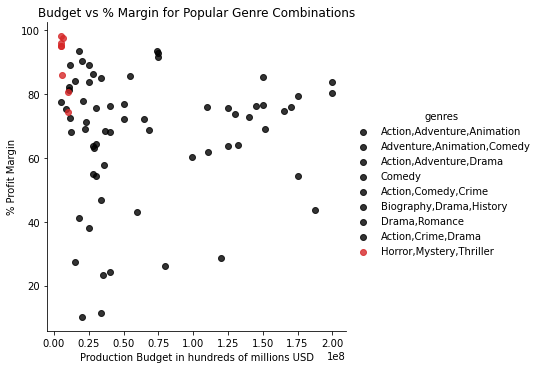

In [23]:
### Creating a list of the top 8 genre combinations
popular_genres = list(df['genres'].value_counts().index[0:9])
df_genre_profitability = df[df['genres'].isin(popular_genres)]


ax2 = sns.lmplot( x="production_budget", 
           y="profit_margin", 
           data=df_genre_profitability, 
           fit_reg=False, 
           hue='genres', 
           legend=True, 
           height=5, 
           aspect=1,
           palette=["k", "k", "k", "k", "k", "k" ,"k" , "k", "C3"])
ax2.set(xlabel = "Production Budget in hundreds of millions USD", ylabel = "% Profit Margin", title = "Budget vs % Margin for Popular Genre Combinations")
plt.show()

Recommendation: As seen above, there is a tight clustered relation between profit margin and production budget for the horror, mystery, and thriller space. All three of these genres are typically under represented by the profitable studios as seen in the bar chart above. Let's go one further and see which studios go the best with horror films.

<h2 style="font-weight: 100">Top Profitable Horror, Mystery, and Thriller Studios</h2>

In [24]:
target_genres = ['Horror', 'Horror,Mystery,Thriller', 'Horror,Thriller']
df_horror = df[df['genres'].isin(target_genres)]

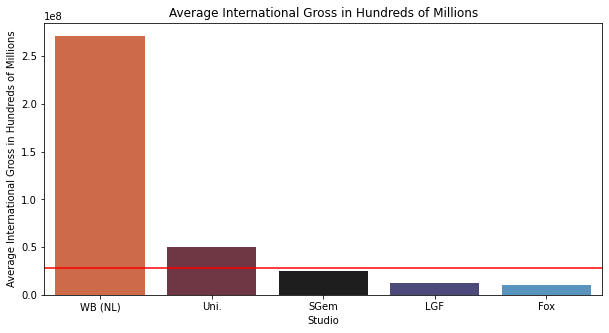

In [25]:
plt.figure(figsize=(10, 5))
plot_order = df_horror.groupby('studio')['international_gross'].mean().sort_values(ascending=False).index.values
ax = sns.barplot(x='studio', y='international_gross', data=df_horror, palette="icefire_r", ci=None, order=plot_order)
ax.set(xlabel = "Studio", ylabel = "Average International Gross in Hundreds of Millions", title = "Average International Gross in Hundreds of Millions")
plt.axhline(df_horror['international_gross'].median(), label ='Mean Intl Gross', color ='red')
plt.show()

<h1 style="font-weight: normal">Evaluation</h1>

The lessons learned from the most profitable studios are:
   - Runtime should stay at around 107 minutes
   - International box office returns increase exponetially as budget increases
   - Horror, Mystery, and Thriller genres are underrepresented but highly lucrative
   - If Microsoft were to persue a partnership in this field, they should partner with WB (NL) who have major horror blockbusters such as Annabelle and the IT series



<h1 style="font-weight: normal">Conclusions</h1>

- There are important lessons to be learned about the most profitable studios in the industry and the business landscape they operate in.

- Our sample of profitable movies from profitable studios was limited to 10 studios and 192 feature films. This was chosen for reasons explained in data filtering, but we could expand to other studios given more time to provide further insight.

- We could also continue our studio analysis to identify the top people in the business as well as additional analysis on the critic and user reviews of each movie and see if there is a correlation with return on investment